In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.6817 - loss: 0.3868 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 6.4350e-05 - val_accuracy: 1.0000 - val_loss: 2.9857e-04
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 1.0781e-05 - val_accuracy: 1.0000 - val_loss: 9.2182e-05
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.2067e-06 - val_accuracy: 1.0000 - val_loss: 3.9376e-05
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.3162e-06 - val_accuracy: 1.0000 - val_loss: 2.0997e-05
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 6.8240e-07 - val_accuracy: 1.0000 - val_loss: 1.3124e-05
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 4.2432e-07 - val_accu

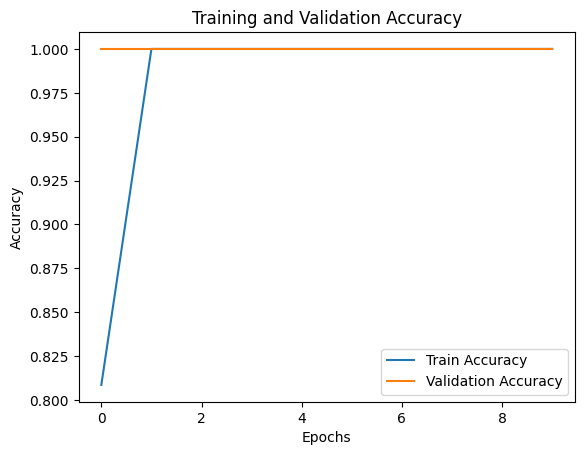

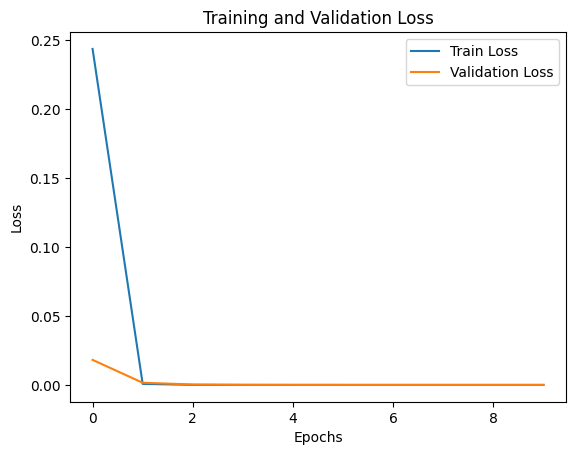

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


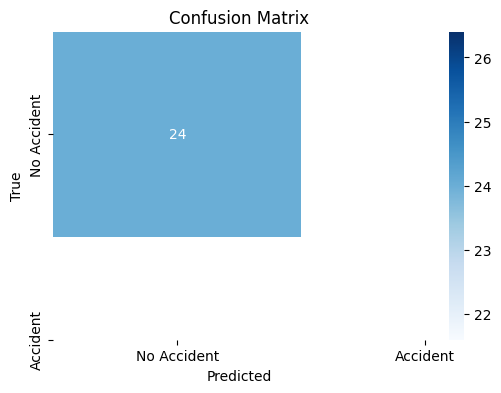

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


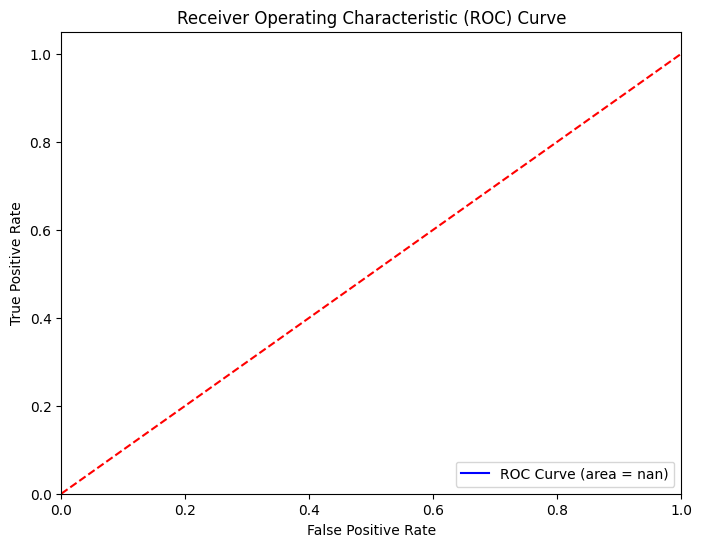

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


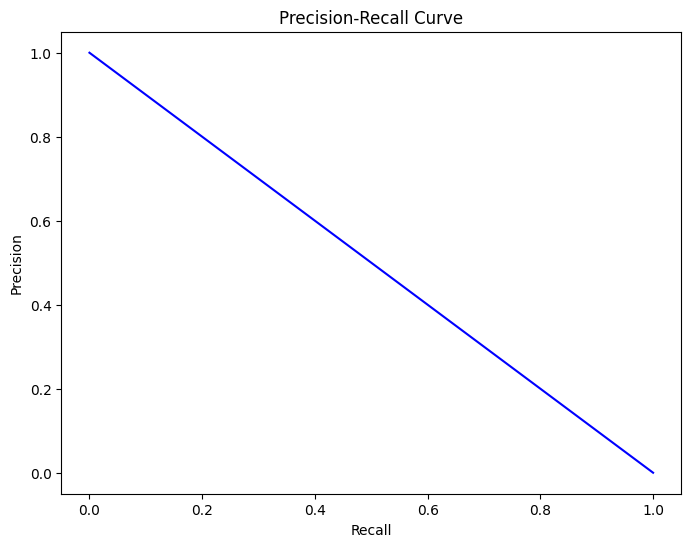

In [2]:
import cv2
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비 (이미지와 레이블 준비)
def load_images_and_labels(dataset_path, image_size=(224, 224)):
    image_files = [f"{i:03d}.png" for i in range(1, 151)]  # 예시: 001.png ~ 150.png
    images = []
    labels = []  # 1: 사고 발생, 0: 사고 미발생 (예시 레이블)

    for image_file in image_files:
        image_path = os.path.join(dataset_path, image_file)

        # 파일이 존재하는 경우
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            image_resized = cv2.resize(image, image_size)  # 모델에 맞게 이미지 크기 조정
            image_normalized = image_resized / 255.0  # 정규화
            images.append(image_normalized)

            # 레이블 추가 (예시로 0 또는 1 값을 할당)
            if 'accident' in image_file:  # 예시 조건: 사고 관련 파일에는 'accident' 포함
                labels.append(1)  # 사고 발생
            else:
                labels.append(0)  # 사고 미발생

    return np.array(images), np.array(labels)

# 2. 데이터 로딩
dataset_path = '/content/drive/MyDrive/dataset/case1/'  # 실제 데이터셋 경로로 설정
X, y = load_images_and_labels(dataset_path)

# 3. 훈련 데이터와 검증 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 데이터 증강 (이미지 회전, 이동, 확대 등)
datagen = ImageDataGenerator(
    rescale=1.0/255.0,   # 이미지를 0~1로 정규화
    rotation_range=20,   # 이미지 회전
    width_shift_range=0.2,  # 좌우 이동
    height_shift_range=0.2,  # 상하 이동
    shear_range=0.2,     # 기울이기
    zoom_range=0.2,      # 확대
    horizontal_flip=True, # 좌우 반전
    fill_mode='nearest'
)

# 5. 모델 정의 (예시: MobileNetV2 + Fully Connected Layer)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # 기본 모델의 가중치는 동결

# 모델 설계
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 사고 발생(1) / 미발생(0) 이진 분류
])

# 6. 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. 모델 학습
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)

# 8. 모델 저장
model.save('/content/drive/MyDrive/accident_prediction_model.h5')

# 9. 훈련 및 검증 정확도/손실 함수 시각화
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 정확도와 손실 함수 시각화
plot_accuracy(history)
plot_loss(history)

# 10. Confusion Matrix 시각화
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype('int')  # 확률을 0.5 임계값으로 이진 분류

cm = confusion_matrix(y_val, y_pred_classes)

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Accident', 'Accident'], yticklabels=['No Accident', 'Accident'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm)

# 11. ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(fpr, tpr, roc_auc)

# 12. Precision-Recall Curve 시각화
precision, recall, _ = precision_recall_curve(y_val, y_pred)

def plot_precision_recall_curve(precision, recall):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

plot_precision_recall_curve(precision, recall)
